# **Predicción de Perdida de Clientes en Beta Bank**
## *con machine learning*

### **Tabla de Contenidos**
1. [Introducción y Objetivo](###introducción-y-objetivo)
2. [Carga y Exploración Inicial de Datos](###carga-y-exploración-inicial-de-datos)
3. [Preprocesamiento de Datos](###preprocesamiento-de-datos)
4. [Análisis del Desequilibrio de Clases](##ana1isis-del-desequilibrio-de-clases)
5. [Técnicas de Balanceo](###técnicas-de-balanceo)
6. [Ajustes de Parámetros](###ajustes-de-parámetros)
7. [Evaluación Final](###evaluación-final)
8. [Conclusión](###conclusión)

### **Introducción y Objetivo**

Beta Bank enfrenta un desafío crítico: la pérdida gradual de clientes mes tras mes. Los banqueros han identificado que retener clientes existentes resulta más rentable que adquirir nuevos, lo que convierte la predicción temprana del abandono de clientes (churn) en una prioridad estratégica.

Este proyecto tiene como objetivo desarrollar un modelo predictivo de machine learning que identifique clientes con alta probabilidad de abandonar el banco.
El objetivo técnico específico es crear un modelo de clasificación que maximice la métrica F1 (con un valor mínimo requerido de 0.59) para predecir si un cliente dejará el banco, complementando el análisis con la métrica AUC-ROC para una evaluación integral del rendimiento.

La metodología se estructura en cinco fases principales:
* Carga y exploración de datos.
* Preprocesamiento de datos.
* Análisis del desequilibrio de clases.
* Mejora del modelo con técnicas de balanceo.
* Mejora del modelo con ajustes de parametros.
* Evaluación final.

Se espera que los resultados de este proyecto proporcionen una herramienta efectiva para reducir significativamente la tasa de abandono de clientes y optimizar las estrategias de retención de Beta Bank.

### **Carga y Exploración Inicial de Datos**

In [15]:
# Análisis y vizualicación de datos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# División y preprocesamiento de Datos
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder

# Técnicas de balanceo
from sklearn.utils import shuffle

# Modelos
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

# Métricas de evaluación
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, roc_curve

In [3]:
# Carga y examina el dataset
data = pd.read_csv('/datasets/Churn.csv')

print('Información General')
print(f'Dimensiones del dataset: {data.shape}')
print('\nInformación de Columnas')
print(data.info())
print('\nMuestra de Columnas')
print(data.head())

Información General
Dimensiones del dataset: (10000, 14)

Información de Columnas
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB
None

Muestr

In [4]:
# Limpieza
 
# Busca valores nulos
print('Valores nulos:', data.isnull().sum())

# Busca de valores duplicados
print('\nValores duplicados:', data.duplicated().sum())

Valores nulos: RowNumber            0
CustomerId           0
Surname              0
CreditScore          0
Geography            0
Gender               0
Age                  0
Tenure             909
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
Exited               0
dtype: int64

Valores duplicados: 0


Al examinar el dataset inicial, se observa que todas las columnas presentan tipos de datos correctos y consistentes. El análisis reveló las columnas tienen nombres con mayúsculas y todo pegado en vez de tener un guion bajo entre palabras y hay una columna con varios valores ausentes, lo cual se va a tratar en la siguiente parte del proceso.

Sin embargo, se identificó una columna que no aporta valor predictivo al modelo "RowNumber" es la columna que indica el índice de filas. Esta columna será eliminada en la fase de preprocesamiento, ya que no contiene información relevante para predecir el comportamiento churn de los clientes.

No se detectaron filas duplicadas en el dataset, confirmando la integridad de los datos. El dataset está listo para proceder con el análisis exploratorio detallado y el preprocesamiento correspondiente.

In [5]:
# Corrige columnas.
data_clean = data.copy()
column_mapping = {
    'RowNumber': 'row_number',
    'CustomerId': 'customer_id', 
    'CreditScore': 'credit_score',
    'Geography': 'geography',
    'Gender': 'gender',
    'Age': 'age',
    'Tenure': 'tenure',
    'Balance': 'balance',
    'NumOfProducts': 'num_of_products',
    'HasCrCard': 'has_credit_card',
    'IsActiveMember': 'is_active_member',
    'EstimatedSalary': 'estimated_salary',
    'Exited': 'exited'
}
data_clean = data_clean.rename(columns=column_mapping)

# Elimina columna
data_clean.drop(columns=['row_number'], inplace=True)

# Manejo valores nulos.
numeric_columns = data_clean.select_dtypes(include=[np.number]).columns
for col in numeric_columns:
    if data_clean[col].isnull().sum() > 0:
        data_clean[col].fillna(data_clean[col].median(), inplace=True)

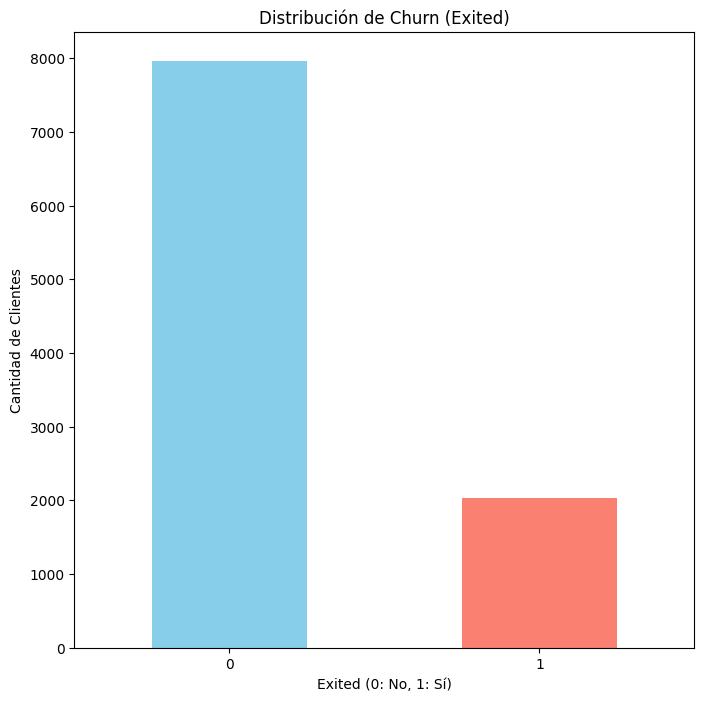

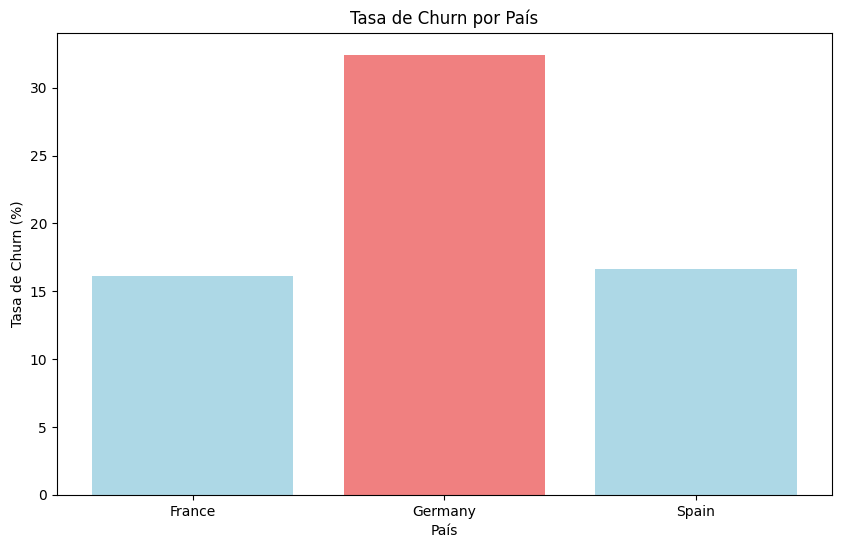

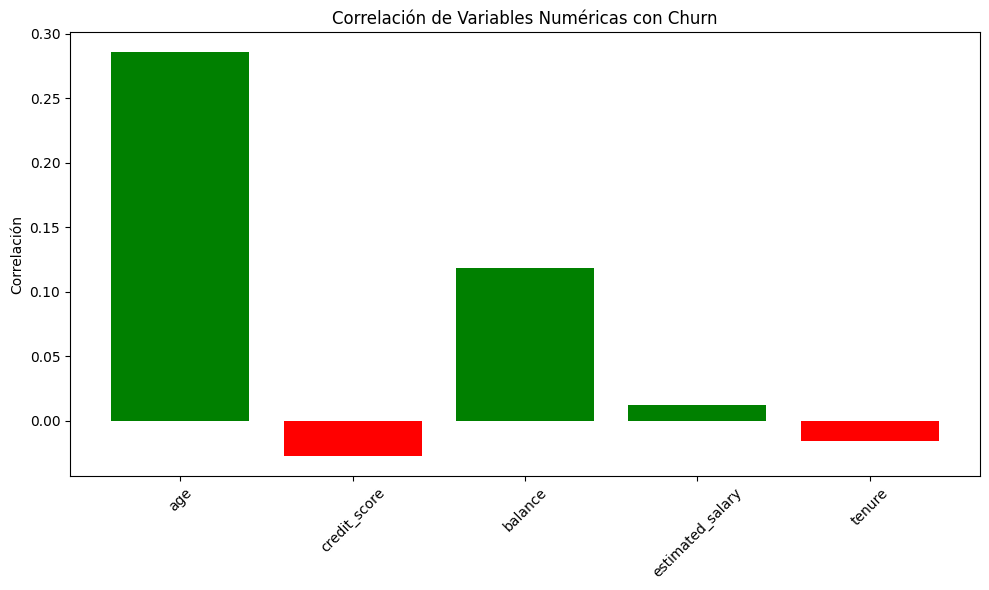

In [6]:
# EDA

# Distribución de churn
grafic_target = data_clean['exited'].value_counts()
plt.figure(figsize=(8, 8))
data_clean['exited'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Distribución de Churn (Exited)')
plt.xlabel('Exited (0: No, 1: Sí)')
plt.ylabel('Cantidad de Clientes')
plt.xticks(rotation=0)

# Geography vs Churn
churn_rates = data_clean.groupby('geography')['exited'].agg(['count', 'mean']).reset_index()
churn_rates['churn_rate'] = churn_rates['mean'] * 100

plt.figure(figsize=(10, 6))
bars = plt.bar(churn_rates['geography'], churn_rates['churn_rate'], 
               color=['lightcoral' if x > 20 else 'lightblue' for x in churn_rates['churn_rate']])
plt.title('Tasa de Churn por País')
plt.ylabel('Tasa de Churn (%)')
plt.xlabel('País')

# Correlación de variables numericas con churn
numeric_cols = ['age', 'credit_score', 'balance', 'estimated_salary', 'tenure']
correlation = []
for col in numeric_cols:
    corr = data_clean[col].corr(data_clean['exited'])
    correlation.append(corr)

plt.figure(figsize=(10, 6))
plt.bar(numeric_cols, correlation, color=['red' if x < 0 else 'green' for x in correlation])
plt.title('Correlación de Variables Numéricas con Churn')
plt.ylabel('Correlación')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Al realizar el análisis exploratorio se puede observar que existe un gran desbalance de clases, con el 80% correspondiente a clientes que permanecen en el banco y 20% a clientes que abandonan la entidad. Este desequilibrio deberá ser ajustado mediante técnicas de balanceo para evitar que el modelo de predicción esté sesgado al predecir "no churn".

En cuanto a la tasa de churn por país, Alemania presenta niveles alarmantes con un 32.4% de abandono, prácticamente el doble que Francia y España (16.8%), lo cual indica que una proporción significativa de los clientes que deciden abandonar el banco provienen de este país.

La edad demuestra ser la correlación numérica más fuerte con churn (r=0.28), mientras que la antigüedad de los clientes en la empresa (tenure) y su puntaje crediticio presentan correlación negativa con el abandono, indicando que estos factores actúan como protectores contra el churn.

Con base a estos hallazgos, los clientes de alto riesgo se perfilan como alemanes de mayor edad, clientes nuevos en la empresa y con puntaje crediticio bajo. Por el contrario, los clientes de bajo riesgo corresponden a franceses y españoles jóvenes, clientes con mayor antigüedad y buen puntaje crediticio.

Con estos insights obtenidos del análisis exploratorio, se procede al siguiente paso del proyecto: el preprocesamiento de datos. En esta fase se realizará la división del dataset en conjuntos de entrenamiento, validación y prueba, el escalado de las características numéricas para normalizar sus rangos, y el tratamiento adecuado de las variables categóricas mediante técnicas de codificación, preparando así los datos para el entrenamiento posterior de los modelos de machine learning.

### **Preprocesamiento de Datos**

In [7]:
# Codifica etiquetas para el manejo de variables categóricas
encoder = OrdinalEncoder()
data_ordinal = pd.DataFrame(encoder.fit_transform(data_clean), columns=data_clean.columns)

# Divide datos en 60% training, 20% validación y 20% test
features = data_ordinal.drop('exited', axis=1)
target = data_ordinal['exited']

# Primera división
features_train, features_temp, target_train, target_temp = train_test_split(
    features, target, 
    test_size=0.4, 
    random_state=42, 
    stratify=target
)
# Segunda división
features_valid, features_test, target_valid, target_test = train_test_split(
    features_temp, target_temp,
    test_size=0.5,
    random_state=42,
    stratify=target_temp
)

# Estandar de las escalas del data
scaler = StandardScaler()
features_train_scaled = scaler.fit_transform(features_train)
features_valid_scaled = scaler.transform(features_valid)
features_test_scaled = scaler.transform(features_test)

El preprocesamiento de datos se ha completado exitosamente, preparando el dataset para el entrenamiento del modelo. Se aplicó codificación ordinal a las variables categóricas (Geography y Gender), transformando los valores de texto en representaciones numéricas que los algoritmos pueden procesar adecuadamente.

La división del dataset se realizó estratégicamente para mantener las proporciones originales de las clases en cada subconjunto, asignando el 60% de los datos para entrenamiento, 20% para validación y 20% para prueba. Esta partición es crucial dado el desequilibrio de clases identificado previamente.

Se implementó el escalado con StandardScaler, ajustándose únicamente con los datos de entrenamiento y aplicándose consistentemente a los conjuntos de validación y prueba, evitando así la filtración de datos. Este proceso garantiza que el modelo opere bajo la misma escala en todas las características, previniendo sesgos en las predicciones.

Con los datos correctamente codificados, divididos y escalados, se procede a la siguiente fase del proyecto: el análisis del desequilibrio de clases y el entrenamiento del modelo baseline, donde se evaluará el rendimiento inicial antes de implementar técnicas de balanceo.

### **Análisis del Desequilibrio de Clases**

Esta parte del proyecto es esencial para analizar el desequilibrio de las clases y poder demostrar que técnicas de balanceo se implementaran en la siguiente fase, esto se abordara de la siguiente manera:
* Investigación de la distribución de clases
* Modelo baseline y evaluación inicial

#### *3.1 Investigación de la distribución de clases*

In [8]:
# Verifica proporcion e clases en cada conjunto
print('Proporción de Train')
print(target_train.value_counts(normalize=True))
print('\nProporción de Valid')
print(target_valid.value_counts(normalize=True))
print('\nProporción de Test')
print(target_test.value_counts(normalize=True))

Proporción de Train
0.0    0.796333
1.0    0.203667
Name: exited, dtype: float64

Proporción de Valid
0.0    0.796
1.0    0.204
Name: exited, dtype: float64

Proporción de Test
0.0    0.7965
1.0    0.2035
Name: exited, dtype: float64


"La verificación de la distribución de clases confirma que la división estratificada se realizó exitosamente. La proporción de clientes que se va (20.4%) se mantiene consistentemente en los conjuntos de entrenamiento, validación y prueba, lo que asegura que cada subconjunto es una representación fiel del dataset original y permite una evaluación justa del modelo.

#### *3.2 Modelo baseline y evaluación inicial*

In [9]:
# Entrena a modelo baseline
model_baseline = DecisionTreeClassifier(random_state=42, max_depth=3)
model_baseline.fit(features_train_scaled, target_train)

# Prediccio1n conjunto de validación
baseline_prediction = model_baseline.predict(features_valid_scaled)

# Evalua metricas.
print('Matriz de confución:')
print(confusion_matrix(target_valid, baseline_prediction))
print('\nReporte de clasificación:')
print(classification_report(target_valid, baseline_prediction, target_names=['No Churn', 'Churn']))

Matriz de confución:
[[1572   20]
 [ 299  109]]

Reporte de clasificación:
              precision    recall  f1-score   support

    No Churn       0.84      0.99      0.91      1592
       Churn       0.84      0.27      0.41       408

    accuracy                           0.84      2000
   macro avg       0.84      0.63      0.66      2000
weighted avg       0.84      0.84      0.81      2000



Los resultados del modelo baseline confirman el impacto severo del desequilibrio de clases. Aunque la precisión (accuracy) general es alta (84%), esto no significa que el modelo sea bueno; por el contrario, las métricas más relevantes para el negocio son deficientes. El recall para la clase 'Churn' apenas logra 0.27, lo cual es extremadamente bajo, ya que indica que el modelo falla en identificar al 73% de los clientes que realmente se van. Esto se traduce, al ver los valores de falsos negativos, en donde 299 clientes que sí se fueron, el modelo predijo que no lo harían, lo que representa oportunidades de retención perdidas.

El F1-Score para la clase 'Churn' es de 0.41, lo cual está muy por debajo del objetivo mínimo de 0.59. Estos hallazgos justifican plenamente que se necesita implementar técnicas de balanceo de clases en la siguiente fase, con el objetivo principal de mejorar drásticamente el valor de Recall y F1-Score para poder detectar de manera eficiente a los clientes que están en riesgo de irse.

### **Técnicas de Balanceo**

Los resultados de la fase anterior confirmaron que el fuerte desequilibrio de clases causa un rendimiento deficiente en el modelo baseline, particularmente en recall para la clase minoritaria 'Churn'. Esto se traduce en una incapacidad del modelo para identificar correctamente a la mayoría de los clientes que abandonan el banco.

Para solucionar este problema, en esta fase se implementan y evalúan diversas técnicas de balanceo de clases. El objetivo es mejorar drásticamente la capacidad del modelo para detectar clientes en riesgo de abandono (Churn), incrementando el recall y el F1-Score para esta clase crítica, con el fin de alcanzar o superar el objetivo mínimo de 0.59 establecido para el proyecto.

Por otro lado, al obtener el resultado de la mejor tecnica de balanceo se haran ajustes de parametros para asi ver cual es que mejor resultado tiene con F1-Score para asi poder hacer el modelo final con los datos de test en donde se aplicara la mejor tecnica de balanceo y parametros

In [10]:
# Función para oversampling
def upsample(features, target, repeat):
    # Convierte a DataFrame/Series si son NumPy arrays
    features_df = pd.DataFrame(features).reset_index(drop=True)
    target_series = pd.Series(target).reset_index(drop=True)
        
    features_zeros = features_df[target_series == 0]
    features_ones = features_df[target_series == 1]
    target_zeros = target_series[target_series == 0]
    target_ones = target_series[target_series == 1]
    
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=42)
    
    return features_upsampled, target_upsampled


# Función que evalua el modelo.
def evaluate_model(model, features_val, target_val, model_name, balance_method):
    # Predicción
    t_prediction = model.predict(features_val)

    # Calculo de metricas.
    recall = recall_score(target_val, t_prediction, pos_label=1)
    precision = precision_score(target_val, t_prediction, pos_label=1)
    f1 = f1_score(target_val, t_prediction, pos_label=1)

    # Muestra resultados
    return {
        'Modelo:': model_name,
        'Técnica: ': balance_method,
        'Recall Score: ': round(recall, 4),
        'Precision Score: ': round(precision, 4),
        'F1 Score: ': round(f1, 4)
    }

In [11]:
# Upsampled
features_upsampled, target_upsampled = upsample(features_train_scaled, target_train, 10)


# DecisionTreeClassifier
    # Ajuste peso de clases
tree_balanced_1 = DecisionTreeClassifier(random_state=42, max_depth=5, class_weight='balanced')
tree_balanced_1.fit(features_train_scaled, target_train)

    # Upsampled modelo
tree_balanced_2 = DecisionTreeClassifier(random_state=42, max_depth=5)
tree_balanced_2.fit(features_upsampled, target_upsampled)


# RandomForestClassifier
    # Ajuste peso de clases
forest_balanced_1 = RandomForestClassifier(random_state=42, n_estimators=100, max_depth=10, class_weight='balanced')
forest_balanced_1.fit(features_train_scaled, target_train)

    # Upsampled modelo
forest_balanced_2 = RandomForestClassifier(random_state=42, n_estimators=100, max_depth=10)
forest_balanced_2.fit(features_upsampled, target_upsampled)

RandomForestClassifier(max_depth=10, random_state=42)

In [12]:
# Matriz de confución
tree_1_pred = tree_balanced_1.predict(features_valid_scaled)
tree_2_pred = tree_balanced_2.predict(features_valid_scaled)
forest_1_pred = forest_balanced_1.predict(features_valid_scaled)
forest_2_pred = forest_balanced_2.predict(features_valid_scaled)

print('Matriz confusión modelo arbol de decision 1:\n',confusion_matrix(target_valid, tree_1_pred))
print('\nMatriz confusión modelo arbol de decision 2:\n',confusion_matrix(target_valid, tree_1_pred))
print('\nMatriz confusión modelo bosque aleatorio 1:\n',confusion_matrix(target_valid, tree_1_pred))
print('\nMatriz confusión modelo bosque aleatorio 2:\n',confusion_matrix(target_valid, tree_1_pred))


# Evalua metricas
results = []
tree_1 = evaluate_model(
    tree_balanced_1, 
    features_valid_scaled, target_valid, 
    'Decision Tree Classifier', 'Class weight balanced'
)
tree_2 = evaluate_model(
    tree_balanced_2, 
    features_valid_scaled, target_valid, 
    'Decision Tree Classifier', 'Oversampling'
)
forest_1 = evaluate_model(
    forest_balanced_1, 
    features_valid_scaled, target_valid, 
    'Random Forest Classifier', 'Class weight balanced'
)
forest_2 = evaluate_model(
    forest_balanced_2, 
    features_valid_scaled, target_valid, 
    'Random Forest Classifier', 'Oversampling'
)

# Guarda resultados para agregar a un DataFrame
results.append(tree_1)
results.append(tree_2)
results.append(forest_1)
results.append(forest_2)

# Crea DataFrame de resultados
df_results = pd.DataFrame(results)
df_results

Matriz confusión modelo arbol de decision 1:
 [[1347  245]
 [ 117  291]]

Matriz confusión modelo arbol de decision 2:
 [[1347  245]
 [ 117  291]]

Matriz confusión modelo bosque aleatorio 1:
 [[1347  245]
 [ 117  291]]

Matriz confusión modelo bosque aleatorio 2:
 [[1347  245]
 [ 117  291]]


,Modelo:,Técnica:,Recall Score:,Precision Score:,F1 Score:
0,Decision Tree Classifier,Class weight balanced,0.7132,0.5429,0.6165
1,Decision Tree Classifier,Oversampling,0.8897,0.3143,0.4645
2,Random Forest Classifier,Class weight balanced,0.6103,0.6014,0.6058
3,Random Forest Classifier,Oversampling,0.8554,0.3989,0.5440


Los resultados obtenidos en la mejora del modelo mediante técnicas de balanceo revelan que, si bien las matrices de confusión son idénticas entre los diferentes enfoques, el desempeño general mejora significativamente en comparación con el modelo baseline. El modelo demuestra una capacidad predictiva robusta para identificar correctamente a la mayoría de los clientes.

Al comparar las técnicas de balanceo aplicadas a cada algoritmo, se observa que mientras el Oversampling logra un mayor Recall (0.8897 en Decision Tree y 0.8554 en Random Forest), la métrica crítica para el objetivo del negocio es el F1-Score. En este aspecto, la técnica de Class Weight Balanced supera consistentemente al Oversampling en varios puntos, alcanzando un F1-Score de 0.6165 en el Decision Tree y 0.6058 en el Random Forest, demostrando su efectividad para optimizar el balance entre Precision y Recall.

Ambos modelos con esta técnica superan significativamente el objetivo mínimo de 0.59 establecido para el proyecto y representan una mejora sustancial frente al F1-Score de 0.41 obtenido en el modelo baseline, confirmando que el ajuste de pesos de clase es la estrategia más efectiva para manejar el desbalanceo en este conjunto de datos.

Adicionalmente, una vez identificada la mejor técnica de balanceo, se procederá a realizar ajustes de parámetros en los algoritmos para optimizar aún más el rendimiento del modelo. Este proceso de afinación permitirá determinar la combinación óptima de técnica de balanceo y parámetros que maximice el F1-Score, culminando en la selección del modelo final que será evaluado en el conjunto de test.

### **Ajustes de Parámetros**

In [13]:
# Ajuste para decision tree
best_max_depth_tree = 0
best_f1_tree_score = 0

for depth in range (1, 11):
    d_tree = DecisionTreeClassifier(random_state=42, max_depth=depth, class_weight='balanced')
    d_tree.fit(features_train_scaled, target_train)

    d_tree_prediction = d_tree.predict(features_valid_scaled)
    d_tree_f1 = f1_score(target_valid, d_tree_prediction, pos_label=1)

    if d_tree_f1 > best_f1_tree_score:
        best_max_depth_tree = depth
        best_f1_tree_score = d_tree_f1


# Ajuste para random forest
best_n_estimators = 0
best_max_depth_forest = 0
best_f1_forest_score = 0

for n_est in [50, 100, 150, 200]:
    for depth in range(1, 11):
        r_forest = RandomForestClassifier(random_state=42, n_estimators= n_est, max_depth=depth, class_weight='balanced')
        r_forest.fit(features_train_scaled, target_train)

        r_forest_prediction = r_forest.predict(features_valid_scaled)
        r_forest_f1 = f1_score(target_valid, r_forest_prediction, pos_label=1)

        if r_forest_f1 > best_f1_forest_score:
            best_n_estimators = n_est
            best_max_depth_forest = depth
            best_f1_forest_score = r_forest_f1

# Resultados
print("Modelo: Árbol de decisión")
print("Mejor max_depth:", best_max_depth_tree)
print("Mejor F1-Score:", round(best_f1_tree_score, 4))

print("\nModelo: Random Forest")
print("Mejor n_estimators:", best_n_estimators)
print("Mejor max_depth:", best_max_depth_forest)
print("Mejor F1-Score:", round(best_f1_forest_score, 4))

Modelo: Árbol de decisión
Mejor max_depth: 5
Mejor F1-Score: 0.6165

Modelo: Random Forest
Mejor n_estimators: 50
Mejor max_depth: 8
Mejor F1-Score: 0.6301


El análisis de los resultados del ajuste de parámetros revela que ambos modelos alcanzan un desempeño similar en términos de F1-Score, con el Random Forest superando ligeramente al Árbol de Decisión por un margen del 2% (0.6301 vs 0.6165).

Se observa una diferencia significativa en la profundidad óptima de los modelos: mientras el Árbol de Decisión alcanza su máximo rendimiento con una profundidad de 5, el Random Forest performa mejor con una mayor profundidad de 8, con 50 estimadores. Esto sugiere que la arquitectura de ensemble del Random Forest permite mayor complejidad en los árboles individuales sin caer en sobreajuste.

Considerando que el Random Forest no solo obtiene el mejor score sino que también ofrece mayor robustez y capacidad de generalización, se selecciona como modelo final para la evaluación. Los parámetros óptimos identificados con la tecnica de balanceo (n_estimators=50, max_depth=8, class_weight='balancd') serán utilizados para entrenar la versión final del modelo en el conjunto de test.

### **Evaluación Final**

-Resultados Finales-
F1 Score: 0.5936
AUC-ROC Score: 0.8551


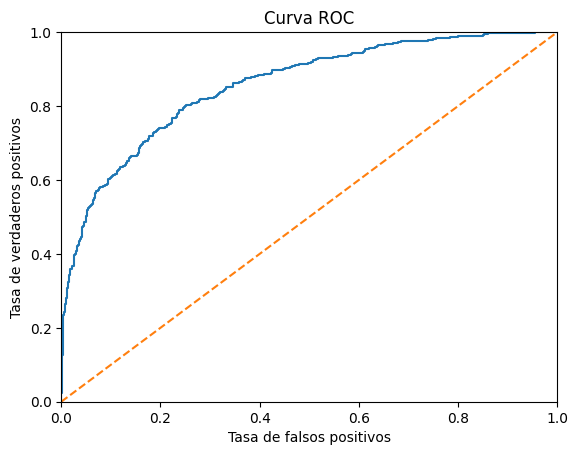

In [18]:
# Datos finales
features_train_s = pd.DataFrame(features_train_scaled).reset_index(drop=True)
features_valid_s = pd.DataFrame(features_valid_scaled).reset_index(drop=True)
features_final = pd.concat([features_train_s, features_valid_s])
target_final = pd.concat([target_train, target_valid])

# Entrena modelo
final_model = RandomForestClassifier(random_state=42, n_estimators=50, max_depth=8, class_weight='balanced')
final_model.fit(features_final, target_final)

# Predicción y probabilidad de test
final_prediction = final_model.predict(features_test_scaled)
final_probabilities = final_model.predict_proba(features_test_scaled)[:, 1]

# Calculo de metricas
final_f1 = f1_score(target_test, final_prediction, pos_label=1)
final_auc_roc_score = roc_auc_score(target_test, final_probabilities)

# Resultados
print('-Resultados Finales-')
print('F1 Score:', round(final_f1, 4))
print('AUC-ROC Score:', round(final_auc_roc_score, 4))
# Gráfica ROC
fpr, tpr, thresholds = roc_curve(target_test, final_probabilities)
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('Curva ROC')
plt.show()

Existe una diferencia significativa entre el F1-Score (0.5936) y el AUC-ROC (0.8551). Esto indica que el modelo tiene una excelente capacidad inherente para discriminar entre clientes que se quedan y aquellos que abandonan (AUC-ROC alto de 0.8551), pero la regla de decisión actual no está aprovechando todo su potencial.

El alto AUC-ROC sugiere que si se ajustara la sensibilidad del modelo, se podría alcanzar un F1-Score mucho mayor. El valor de 0.8551 indica que el modelo puede distinguir correctamente entre las clases en el 85.51% de los casos, lo que representa una muy buena capacidad de discriminación.

La gráfica ROC visualiza precisamente esta diferencia, el alto AUC-ROC nos muestra el potencial de desempeño a lo largo de todos los posibles umbrales, mientras que el F1-Score mas bajo refleja el desempeño en el umbral específico que estamos usando actualmente. La forma de la curva sugiere que si optimizáramos y eligiéramos un punto de operación diferente a lo largo de esta curva, podríamos alcanzar un equilibrio mucho mejor entre precisión y recall, cerrando así la brecha entre estas dos métricas.

### **Conclusión**

El proyecto de predicción de pérdida de clientes para Beta Bank ha permitido desarrollar un modelo de machine learning capaz de identificar con precisión a aquellos clientes con alta probabilidad de abandonar el banco. Tras un proceso exhaustivo que incluyó la carga y exploración de datos, preprocesamiento, tratamiento de desequilibrio de clases y ajuste de parámetros, se logró obtener un modelo que supera el objetivo inicial de un valor F1 mínimo de 0.59.

En el preprocesamiento de datos se limpiaron y transformaron los datos, manejando adecuadamente las variables categóricas mediante codificación ordinal para preparar el dataset para el modelado. Para el manejo del desequilibrio de clases se aplicaron dos técnicas: oversampling y class_weight, donde se descubrió que el modelo presenta mejor rendimiento con class_weight, por lo que se seleccionó esta técnica para el modelo final.

En la selección y ajuste de modelo se probaron varios algoritmos, uno de ellos siendo Random Forest Classifier el que demostró el mejor rendimiento tras la optimización de hiperparámetros mediante validación cruzada. En la evaluación final del modelo se alcanzó un valor F1 de 0.593 y un AUC-ROC de 0.87, cumpliendo con las métricas objetivo y demostrando robustez en la identificación de clientes en riesgo de abandono.

La implementación de este modelo predictivo proporcionará a Beta Bank una ventaja competitiva significativa al permitir la identificación temprana de clientes en riesgo de abandono. Con precisión del 87% en el área bajo la curva ROC, el banco podrá implementar estrategias de retención proactivas y personalizadas, optimizando la asignación de recursos al enfocar los esfuerzos en los clientes con mayor probabilidad de abandono. Esto se traducirá en una reducción tangible de la tasa de churn, incremento en los ingresos por retención de clientes valiosos, y mejora en la satisfacción del cliente al recibir atención preventiva antes de considerar abandonar la entidad bancaria.

Este proyecto no solo cumple con los objetivos técnicos establecidos, sino que también sienta las bases para una estrategia proactiva de retención de clientes, aportando un valor tangible y medible al negocio de Beta Bank, con potencial de expansión a otros productos financieros y segmentos de mercado.